In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [40]:
path = 'hillary-clinton-emails/Emails.csv'
data = pd.read_csv(path, sep=',')

In [107]:
data.dropna(subset=['ExtractedBodyText'], inplace=True)
data.dropna(subset=['ExtractedSubject'], inplace=True)

In [108]:
def getRawText():
    subjectData = data[data.ExtractedSubject.notnull()].ExtractedSubject.astype(str)
    bodyData = data[data.ExtractedBodyText.notnull()].ExtractedBodyText.astype(str)
    rawText = ' '.join(subjectData) + ' ' + ' '.join(bodyData)
    rawText = rawText.replace('\n', ' ')
    return rawText

## 1. Generate a word cloud based on the raw corpus 

### 1.1 Word cloud without preprocessing

In [109]:
rawText = getRawText()

In [110]:
wordcloud = WordCloud().generate(rawText)

(-0.5, 399.5, 199.5, -0.5)

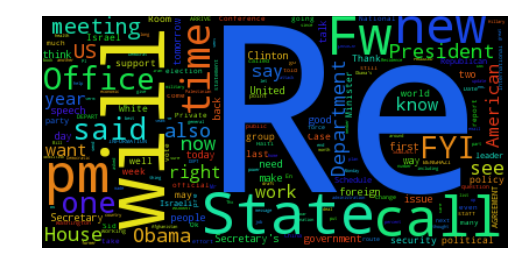

In [111]:
plt.imshow(wordcloud)
plt.axis("off")

### 1.2 Word cloud with preprocessing 

In [184]:
def filterStopWords(text):
    try:
        tokens = nltk.word_tokenize(text)
    except:
        nltk.download()
        tokens = nltk.word_tokenize(text)
    stopWords = stopwords.words('english')
    customWords = ['re','fw','pm','am', 'also', 'and', 'fyi', 'tomorrow', 'today',
                   'well', '.', ',', '"', "'", '?', '&','/', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}', '@', '<', '>', '-', "n't"]
    stopWords += customWords
    filtered = list()
    for token in tokens:
        token = token.lower()
        if token not in stopWords:
            filtered.append(token)
    return filtered

#http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
def lemmAndStem(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    stemmed = [stemmer.stem(lema) for lema in lemmatized]
    return stemmed

def preprocess(text):
    filtered = filterStopWords(text)
    processed = lemmAndStem(filtered)
    return ' '.join(processed)

In [185]:
procText = preprocess(rawText)

(-0.5, 399.5, 199.5, -0.5)

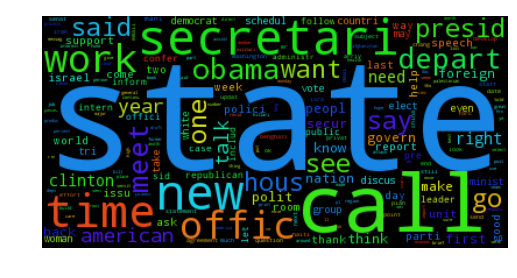

In [186]:
wordcloud = WordCloud().generate(procText)
plt.imshow(wordcloud)
plt.axis("off")

## 2. Sentiment Analysis

https://www.kaggle.com/operdeck/d/kaggle/hillary-clinton-emails/hillary-s-sentiment-about-countries

In [187]:
import pycountry
list_countries = list(pycountry.countries)
accumulator = {}
list_token = rawText.split()
for country in list_countries:
    suma =  list_token.count(country.name) + list_token.count(country.alpha_2) + list_token.count(country.alpha_3.lower())
    accumulator[country.name] = suma

In [179]:
dataset = pd.Series(accumulator, dtype='str')
proba 

American Samoa                2021
Armenia                       1144
Austria                       1640
Belarus                       1434
Belgium                       2050
Iceland                       3943
India                         6579
Italy                         1644
Saint Pierre and Miquelon     1149
Tonga                        11924
dtype: object

In [180]:
proba

American Samoa                2021
Armenia                       1144
Austria                       1640
Belarus                       1434
Belgium                       2050
Iceland                       3943
India                         6579
Italy                         1644
Saint Pierre and Miquelon     1149
Tonga                        11924
dtype: object

## Clean Data

In [181]:
import re
def clean_days_month(text):
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'Frebuary', 'March', 'April', 'May', 'June', 'July', 'September',
                 'November', 'December']
    hours = ['AM', 'PM']
    return [word for word in text if word not in week_days and word not in months and word not in hours]
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
def clean_numbers(text):
    return [word for word in text if not is_number(word) ]

def clean_symbol(text):
    tmp = [re.sub(r'[\w\.-]+@[\w\.-]+', '', word)for word in text]
    return [re.sub('[!@#$,:<>\().]', '', word) for word in tmp]

def clean_text(text):
    tmp = clean_symbol(text.split())
    tmp = clean_days_month(tmp)
    return ' '.join(clean_numbers(tmp))

Clean data and tranform the strings to tokens

In [182]:
from nltk.sentiment.util import *
to_token = nltk.tokenize.RegexpTokenizer(r'\w+|\$')
#Cleaning Body of emails
tmp = []
for i in data.ExtractedBodyText.values:
    tmp.append(preprocess(clean_text(i))  )
data['token_Body'] = tmp
data['token_Body'] = data['token_Body'].apply(to_token.tokenize)
#Cleanning Subject of emails
tmp = []
for i in data.ExtractedSubject.values:
    tmp.append(preprocess(clean_text(i))  )
data['token_Subject'] = tmp
data['token_Subject'] = data['token_Subject'].apply(to_token.tokenize)

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pycountry

full_text = data['token_Subject'] + data['token_Body']
list_token = full_text.values.reshape(-1).tolist()

sentiment = (SentimentIntensityAnalyzer().polarity_scores(rawText)['compound']+1)/2
sentiment
'''
list_countries = list(pycountry.countries)
accumulator = {}
for country in list_countries:
    
    suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower())
    accumulator[country.name] = suma
    '''

In [196]:
dataset = pd.Series(accumulator, dtype='str')
proba

American Samoa                2021
Armenia                       1144
Austria                       1640
Belarus                       1434
Belgium                       2050
Iceland                       3943
India                         6579
Italy                         1644
Saint Pierre and Miquelon     1149
Tonga                        11924
dtype: object